In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt

import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt

In [5]:
emails = pd.read_csv("./emails.csv")

In this project, we build a "Spam Classifier". Our dataset consists of 5172 
examples and 3002 features. We have 1500 "Spam" emails and 3672 "Ham". The feature in the index 0 is a number id for each email (not important). The last feature is the class for each email (1 is Spam, 0 is Ham). The rest of the features are words' counts in each email. 

In [6]:
X = emails.drop(columns=["Email No.", "Prediction"])
y = emails[["Prediction"]]

# Create Train, Develop and Test Set


We split our dataset into 70% training set, 20% for development, and 10% to test set. The final model is evaluated against the test set.

In [7]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42, 
                                                    shuffle=True)

In [8]:
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.3,
                                                random_state=42)

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [9]:
# Helper function to create plots
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [48]:
# report is a dictionary to keep track of all models
# and the corresponded f1score on SPAM class.
report = {}

# Base Network

Our base network model has two hidden and an output layer (this architect is totally random).

We are using "MinMax Normalization" to normalize our inputs. Thus, all inputs are in the range of (0,1). 

Next, we have two "Dense" layers with 128 and 256 neurons respectively. Because we use the "ReLU" activation function for our hidden layers we also use the "He normal" class to initialize our weights. This way we prevent our network from suffering from the vanishing/exploding gradients.

For the output layer, we choose the "sigmoid" activation function because our problem is the binary meaning we want to output just two classes (0 or 1).

In [11]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384128    
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 417,409
Trainable params: 417,409
Non-trainable params: 0
_________________________________________________________________


We pick "Adam" optimizer with a default configuration to optimize the "Binary Cross Entropy" (or Log) loss function. Adam optimizer is a combination of the "momentum" and "RMSprop" optimization techniques. Thus, it keeps track of an exponentially decaying average of past gradients and an exponentially decaying average of past squared gradients.

When fitting the model we keep track of the "accuracy", "recall" and "precision" metrics to evaluate our base network against more complex neural networks.

In [ ]:
optimizer = keras.optimizers.Adam()

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history = model.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

(0.0, 0.3269346948014572)

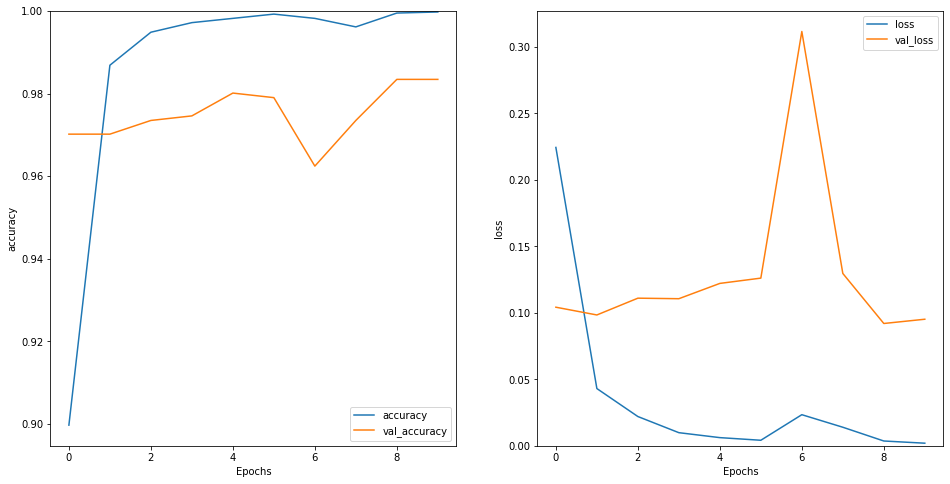

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Based on the above plots our network seems to overfit our dataset. The loss curve on the development dataset starts to increase and on the 6th epoch we have a pick. Then, the network turns back to $0.1$ but still the **validation loss** remains almost 10 times larger than **train loss**.

In [44]:
y_pred = model.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.96      0.97       270
        spam       0.91      0.97      0.94       118

    accuracy                           0.96       388
   macro avg       0.95      0.97      0.96       388
weighted avg       0.96      0.96      0.96       388



We focus on the "Spam" class. Our network has a very high recall, meaning that identifies correctly 97% of the true "Spam" emails. The precision score is above 90% but a bit lower than recall. Precision equals to $.91$ means that our classifier predicts a **ham** email as **spam** almost 1 of 10 times.

In [54]:
report["base_model"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

# Model 1 - Fine Tuning

The learning rate hyperparameter is one of the most significant we need to fine-tune as it handles the optimization of our network. The learning rate is responsible for how fast the network will converge to a global minimum. A too-large learning rate is possible for the network to not converge whereas too small a learning rate is possible to make the training process slow.

In addition, we fine-tune the **# of hidden units** per layer.

In [15]:
def build_model(hp):

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units_2', min_value=32, max_value=512, step=32)

  model = keras.models.Sequential([
      keras.layers.InputLayer(input_shape=(3000,)),
      keras.layers.Dense(hp_units1, activation="relu", kernel_initializer="he_normal"),
      keras.layers.Dense(hp_units2, activation="relu", kernel_initializer="he_normal"),
      keras.layers.Dense(1, activation="sigmoid")
  ])

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

  model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])
  
  return model

In [16]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_precision", direction="max"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='email_classification')

In [17]:
tuner.search(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

Trial 30 Complete [00h 00m 07s]
val_precision: 0.9878453016281128

Best val_precision So Far: 0.9878453016281128
Total elapsed time: 00h 03m 31s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=30)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, the optimal number of units in the second densely-connected
layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64, the optimal number of units in the second densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



In [19]:
model1 = tuner.hypermodel.build(best_hps)

history1 = model1.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

Epoch 1/10
122/122 [==============================] - 2s 8ms/step - loss: 0.2708 - accuracy: 0.8786 - precision: 0.8786 - val_loss: 0.0822 - val_accuracy: 0.9779 - val_precision: 0.9779
Epoch 2/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0464 - accuracy: 0.9874 - precision: 0.9874 - val_loss: 0.0876 - val_accuracy: 0.9757 - val_precision: 0.9757
Epoch 3/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - val_loss: 0.0780 - val_accuracy: 0.9768 - val_precision: 0.9768
Epoch 4/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0109 - accuracy: 0.9969 - precision: 0.9969 - val_loss: 0.0899 - val_accuracy: 0.9812 - val_precision: 0.9812
Epoch 5/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0064 - accuracy: 0.9987 - precision: 0.9987 - val_loss: 0.0840 - val_accuracy: 0.9812 - val_precision: 0.9812
Epoch 6/10
122/122 [==============================] - 1s 5ms/step - lo

(0.0, 0.28423371384851637)

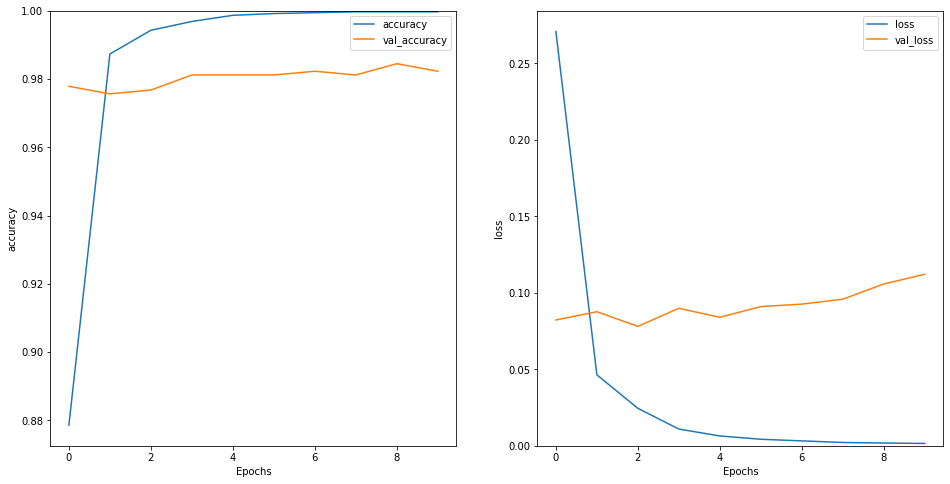

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

In [55]:
y_pred = model1.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       270
        spam       0.93      0.98      0.95       118

    accuracy                           0.97       388
   macro avg       0.96      0.97      0.97       388
weighted avg       0.97      0.97      0.97       388



Above we used the **keras_tuner** package to fine-tune the **learning rate** and the **# of hidden units** per layer. We trained the model with the best hyperparameters and got an **f1score** of $0.95$ slightly better from our base model ($0.94$).

In [56]:
report["model_with_best_hp"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

# Using best hyperparameters - Regularization

Next, we are using the best hyperparameters of the above step and build a new model adding some regularization techniques. 

In [Model 2](https://colab.research.google.com/drive/1uLm9VaTXfUhve3G7E5foxKs5_2ni40ft#scrollTo=WY7Vlfno5mx8&line=1&uniqifier=1) we add two *BatchNormalization*. Previously we mentioned why we use *he_normal* to initialize our inputs' weights. With *BatchNormalization* we actually do the same for the outputs of each layer. Thus, we help our model even more to overpass the vanishing/exploding gradients issue.

In [Model 3](https://colab.research.google.com/drive/1uLm9VaTXfUhve3G7E5foxKs5_2ni40ft#scrollTo=22tmnHNA5wma&line=1&uniqifier=1) we add two regularization layers. **Dropout** technique helps our network to reduce overfitting by shutting down randomly a portion of hidden units per layer in each epoch. Thus, the network doesn't lie on some neurons but instead learns weights to use more of them.

## Model 2 - BatchNormalization

In [22]:
model2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(320, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")                 
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                192064    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 320)               20800     
                                                                 
 batch_normalization_1 (Batc  (None, 320)              1280      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1)                 321       
                                                                 
Total params: 214,721
Trainable params: 213,953
Non-tr

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history2 = model2.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

Epoch 1/10
122/122 [==============================] - 2s 7ms/step - loss: 0.2435 - accuracy: 0.9028 - recall: 0.9028 - precision: 0.9028 - val_loss: 0.5628 - val_accuracy: 0.7149 - val_recall: 0.7149 - val_precision: 0.7149
Epoch 2/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0493 - accuracy: 0.9863 - recall: 0.9863 - precision: 0.9863 - val_loss: 0.4355 - val_accuracy: 0.7691 - val_recall: 0.7691 - val_precision: 0.7691
Epoch 3/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0279 - accuracy: 0.9923 - recall: 0.9923 - precision: 0.9923 - val_loss: 0.2218 - val_accuracy: 0.8807 - val_recall: 0.8807 - val_precision: 0.8807
Epoch 4/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0143 - accuracy: 0.9961 - recall: 0.9961 - precision: 0.9961 - val_loss: 0.0970 - val_accuracy: 0.9591 - val_recall: 0.9591 - val_precision: 0.9591
Epoch 5/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0102 - accuracy: 0.9974 - re

(0.0, 0.5905807374510914)

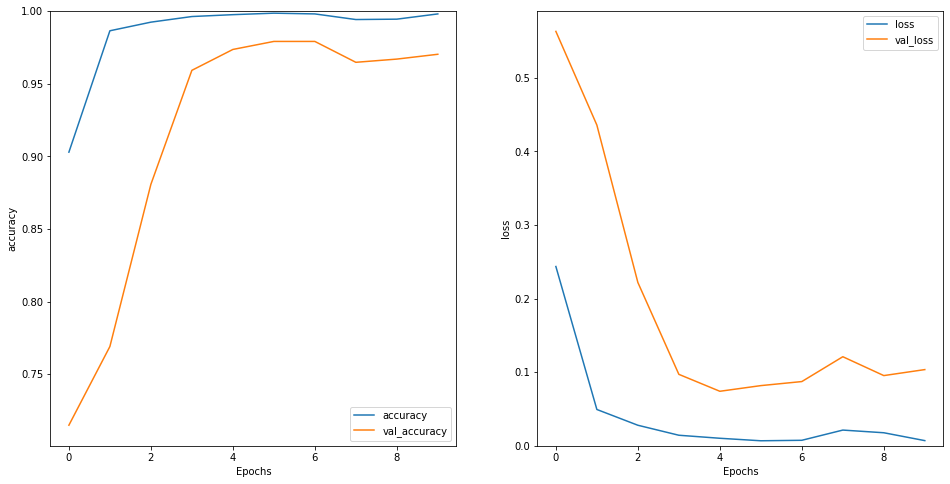

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

In [57]:
y_pred = model2.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       270
        spam       0.92      0.97      0.94       118

    accuracy                           0.96       388
   macro avg       0.95      0.96      0.96       388
weighted avg       0.96      0.96      0.96       388



In [58]:
report["nn_with_bn"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

## Model 3 - Dropout

In [26]:
model3 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(320, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")                 
])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                192064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 320)               20800     
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 321       
                                                                 
Total params: 213,185
Trainable params: 213,185
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__________________________

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model3.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history3 = model3.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

Epoch 1/10
122/122 [==============================] - 1s 7ms/step - loss: 0.3371 - accuracy: 0.8404 - recall: 0.8404 - precision: 0.8404 - val_loss: 0.1033 - val_accuracy: 0.9735 - val_recall: 0.9735 - val_precision: 0.9735
Epoch 2/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0771 - accuracy: 0.9812 - recall: 0.9812 - precision: 0.9812 - val_loss: 0.0613 - val_accuracy: 0.9790 - val_recall: 0.9790 - val_precision: 0.9790
Epoch 3/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0343 - accuracy: 0.9899 - recall: 0.9899 - precision: 0.9899 - val_loss: 0.0583 - val_accuracy: 0.9812 - val_recall: 0.9812 - val_precision: 0.9812
Epoch 4/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0238 - accuracy: 0.9918 - recall: 0.9918 - precision: 0.9918 - val_loss: 0.0843 - val_accuracy: 0.9768 - val_recall: 0.9768 - val_precision: 0.9768
Epoch 5/10
122/122 [==============================] - 1s 5ms/step - loss: 0.0220 - accuracy: 0.9943 - re

(0.0, 0.3536314441822469)

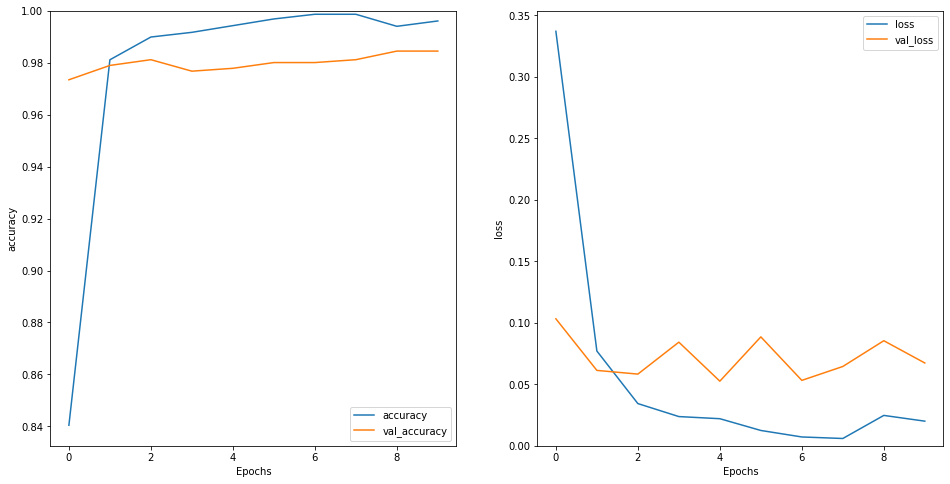

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history3, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history3, 'loss')
plt.ylim(0, None)

In [59]:
y_pred = model3.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       270
        spam       0.96      0.97      0.97       118

    accuracy                           0.98       388
   macro avg       0.97      0.98      0.98       388
weighted avg       0.98      0.98      0.98       388



As expected *BatchNormalization* smooths the loss function and *Dropout* does better on **f1score** for **Spam** emails.

In [60]:
report["nn_with_dropout"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

## All in one

The last model will be the combination of all the above. Thus, we will add *BatchNormalization* and *Dropout* layers.

In [30]:
model4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(320, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")                 
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                192064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 320)               20800     
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 320)              1280      
 hNormalization)                                      

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model4.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history4 = model4.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

(0.0, 0.47759564509615304)

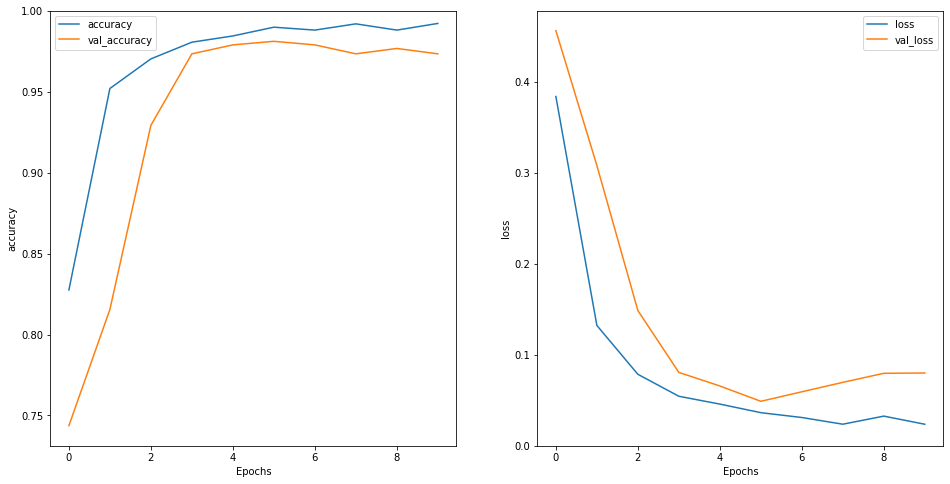

In [36]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history4, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history4, 'loss')
plt.ylim(0, None)

In [61]:
y_pred = model4.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       270
        spam       0.97      0.96      0.96       118

    accuracy                           0.98       388
   macro avg       0.97      0.97      0.97       388
weighted avg       0.98      0.98      0.98       388



In [62]:
report["nn_with_bn_dropout"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

### Adding BatchNormalization Before Dropout

In [34]:
model5 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(320, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")                 
])

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                192064    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 320)               20800     
                                                                 
 batch_normalization_5 (Batc  (None, 320)              1280      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 320)              

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model5.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history5 = model5.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

(0.0, 0.4987489405088127)

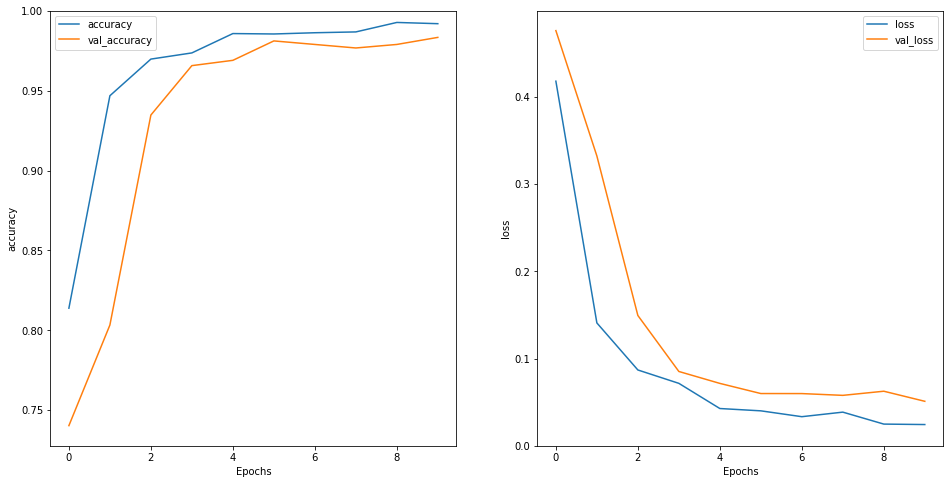

In [37]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history5, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history5, 'loss')
plt.ylim(0, None)

In [63]:
y_pred = model5.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       270
        spam       0.93      0.97      0.95       118

    accuracy                           0.97       388
   macro avg       0.96      0.97      0.96       388
weighted avg       0.97      0.97      0.97       388



In [64]:
report["nn_bn_first"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]

### Adding BatchNormalization Before Activation Function

There is a controversy whether the BatchNormalization should be conducted before or after the activation function. In this step, we apply BatchNormalization before the activation function. The performance of this network is worst than the previous. This means that this isn't the appropriate approach for this project.

In [39]:
model6 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(3000,)),
    keras.layers.Dense(64, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(320, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")                 
])

model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                192064    
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 320)               20800     
                                                                 
 batch_normalization_7 (Batc  (None, 320)              1280      
 hNormalization)                                      

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model6.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.BinaryAccuracy(name='recall'),
                tf.keras.metrics.BinaryAccuracy(name='precision')
              ])

history6 = model6.fit(X_train, np.array(y_train), epochs=10,
                    validation_data=(X_dev, np.array(y_dev)))

(0.0, 0.3713682655245066)

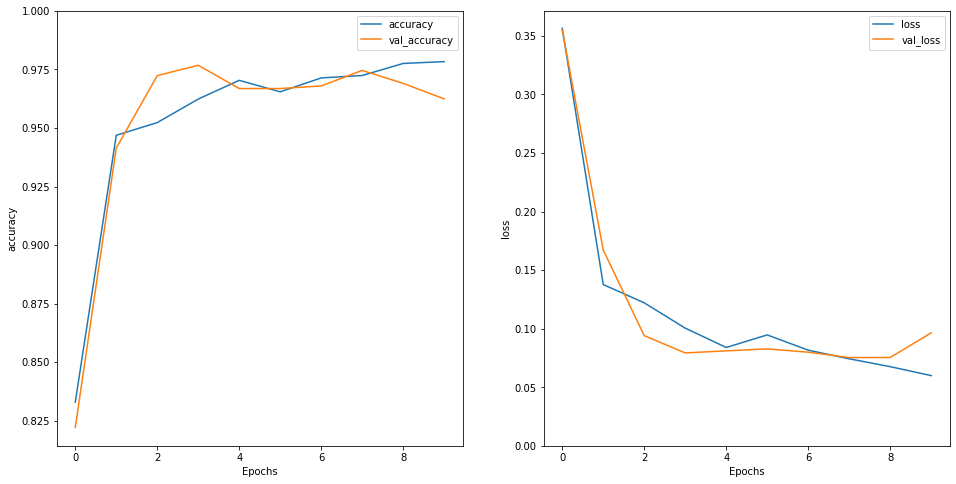

In [41]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history6, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history6, 'loss')
plt.ylim(0, None)

In [65]:
y_pred = model6.predict(X_test) > 0.5

target_names = ["ham", "spam"]
print(classification_report(np.array(y_test), y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       1.00      0.93      0.96       270
        spam       0.85      0.99      0.92       118

    accuracy                           0.95       388
   macro avg       0.93      0.96      0.94       388
weighted avg       0.95      0.95      0.95       388



In [66]:
report["nn_activation_last"] = classification_report(np.array(y_test), y_pred, target_names=target_names, output_dict=True)["spam"]["f1-score"]



---


---





In [69]:
report_df = pd.DataFrame.from_dict(report, orient="index", columns=["f1-score"], dtype=np.float16)

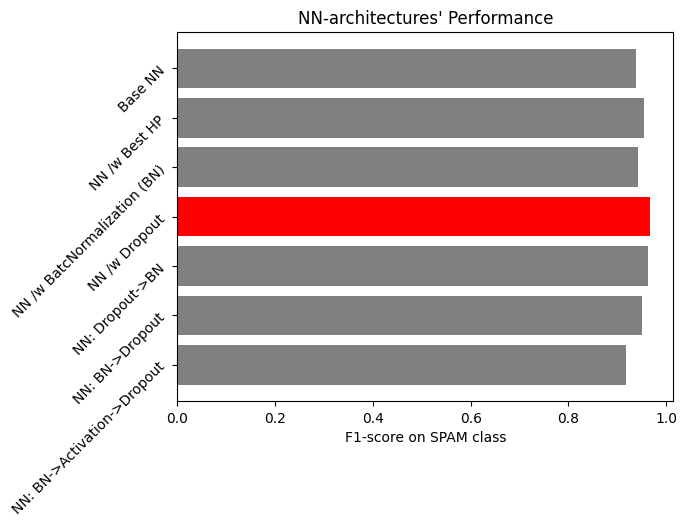

In [91]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y=np.arange(len(report.keys())), width=report_df["f1-score"], color="gray")
ax.barh(y=3, width=report_df["f1-score"].max(), color="red")
ax.set_yticks(ticks=np.arange(len(report.keys())))
ax.set_yticklabels(labels=["Base NN", "NN /w Best HP", "NN /w BatcNormalization (BN)", "NN /w Dropout", "NN: Dropout->BN", "NN: BN->Dropout", "NN: BN->Activation->Dropout"], rotation=45)
ax.invert_yaxis()
ax.set_xlabel("F1-score on SPAM class")
ax.set_title("NN-architectures' Performance")

plt.show()

# Save Model

In [92]:
model3.save("email_classifier.h5")

# Conclusions

In this project, we built a *SPAM classifier*. Our dataset consists of 5000+ instances with 3000 features each (we don't include the id and the prediction). 

We split the dataset into three sets a **train**, a **develop**, and a **test** set. The development set is used for the validation and the test for the final evaluation on **f1-score**. We kept the model with the best f1-score on the SPAM class on the test set.

We built a base neural network randomly chosen to have 2 hidden layers and the output. Then, we fine-tuned it to get the best **hyperparameters** (learning rate and a number of hidden units per layer). Moreover, we add a regularization technique to reduce **variance**.

**Batchnormalization** didn't add much value to the network possibly because we have a small dataset but as expected it smoothed the loss curve. Dropout on the other hand added value to the network and increased the performance by about 3% on the f1-score.

We kept for the final submission the neural network with the dropout layers only based.

### References



*   [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
*   [Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow](https://github.com/ageron/handson-ml2)

